# Modeling

We use a graphical model to understand the 'sequence' of user actions. We compute a transition graph for each user as follows:
    - nodes: 128 actions
    - edges: transition counts for adjacent actions. We normalize for each user.
    
1. Naive Model. 
    - Training: We build 2 training matrices: average graph for users with bookings and without bookings.
    - Prediction: We look at a new user's sequence of actions, then compare it to trained 2 matrices. Metric could be 'simple count', 'Euclidean distance', 'correlation', etc. 
    - Reference: https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/
2. Use matricies as features
    - For each user, we use a unrolled matrix as a feature vector.
    - Run logistic regression.

# TODO
- Performance is still not great yet. We need to tune the model and find a good metric. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train_users_2.csv')
df_s = pd.read_csv('sessions.csv')

In [3]:
df = df[df.country_destination.isin(['NDF', 'US'])]

df.age.fillna(1000, inplace=True)
df['ageCat'] = pd.cut(df['age'], 
                        bins=[0,10,20,30,40,50,60,70,80,90,100,10000])
df_s['action_detail'].fillna('-unknown-', inplace=1)
df_s['action_type'].fillna('-unknown-', inplace=1)

In [4]:
ids_with_session = df[df.id.isin(df_s.user_id)].id.sample(10000, random_state=0)
df = df[df.id.isin(ids_with_session)]
df_s = df_s[df_s.user_id.isin(ids_with_session)]

In [5]:
df.shape

(10000, 17)

In [6]:
df_s.shape

(733507, 6)

In [7]:
actions = [x for x in df_s['action_detail'].unique()]
hash_action_idx = {col:idx for idx, col in enumerate(actions)}
n = len(actions)
n

122

In [8]:
hash_id_book = {id:dest for id, dest in zip(df.id.values, df.country_destination.values)}

# 1. Model 1: build average adjacent matrices

In [9]:
import pyprind

# main adjacent matrices we want to build
mat_book = np.zeros((n,n), dtype=np.float32)
mat_nobook = np.zeros((n,n), dtype=np.float32)

gp = df_s.groupby('user_id')
pbar = pyprind.ProgBar(len(gp))
for id, df_id in gp:
    v = df_id.values
    n_action = v.shape[0]
    book = hash_id_book[id]
    
    mat = np.zeros((n,n), dtype=np.float32)
    for i in range(1, v.shape[0]):
        prev_action = v[i-1,3]
        cur_action = v[i,3]
        prev_idx = hash_action_idx[prev_action]
        cur_idx = hash_action_idx[cur_action]
        mat[prev_idx, cur_idx] += (1/n_action)
        
    if book == 'NDF':
        mat_nobook += mat
    else:
        mat_book += mat
    pbar.update()
    
mat_book = mat_book/df.country_destination.value_counts()['US']*100
mat_nobook = mat_nobook/df.country_destination.value_counts()['NDF']*100

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:04


In [10]:
mat_book

array([[  2.46598329e-02,   1.62640512e-01,   8.55253264e-02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.93583071e-01,   2.52192646e-01,   6.72953367e-01, ...,
          5.44892740e-04,   0.00000000e+00,   0.00000000e+00],
       [  3.92134152e-02,   7.62595117e-01,   8.78876075e-03, ...,
          4.10778826e-04,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   2.12449441e-03,   0.00000000e+00, ...,
          9.37031640e-04,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]], dtype=float32)

In [11]:
mat_nobook

array([[  1.14899604e-02,   1.63872927e-01,   7.27299601e-02, ...,
          7.98556197e-04,   0.00000000e+00,   0.00000000e+00],
       [  1.45152718e-01,   2.74003327e-01,   8.23160529e-01, ...,
          1.16361049e-03,   0.00000000e+00,   0.00000000e+00],
       [  5.02701141e-02,   9.32789385e-01,   1.88677721e-02, ...,
          3.59350303e-03,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  7.56526948e-04,   7.98556197e-04,   1.43740117e-03, ...,
          5.89104253e-04,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   4.68208855e-05,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.91653497e-04]], dtype=float32)

## train accuracy with simple_count score

In [12]:
def simple_count_score(df_user):
    v = df_user.values
    n_action = v.shape[0]
    
    book_score = 0
    for i in range(1, v.shape[0]):
        prev_action = v[i-1,3]
        cur_action = v[i,3]
        prev_idx = hash_action_idx[prev_action]
        cur_idx = hash_action_idx[cur_action]
        
        m1 = mat_book[prev_idx, cur_idx]
        m2 = mat_nobook[prev_idx, cur_idx]
        
        if m1 > m2:
            book_score += 1
        else:
            book_score -= 1
    return book_score/n_action

In [13]:
import pyprind

gp = df_s.groupby('user_id')
pbar = pyprind.ProgBar(len(gp))

scores = []
for id, df_user in gp:
    book = hash_id_book[id]
    book_score = simple_count_score(df_user)
    scores.append((book,book_score))

    pbar.update()    

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:03


In [14]:
df_book_score = pd.DataFrame(scores, columns=['book', 'book_score'])

In [15]:
df_book_score.head()

,book,book_score
0,NDF,-0.967742
1,NDF,0.338983
2,NDF,0.346154
3,US,0.263889
4,US,-0.062500


In [16]:
def map_book(s):
    if s == 'US':
        return 1
    else:
        return 0
    
def map_book_score(t):
    if t >= 0.1:
        return 1
    else:
        return 0
    
df_book_score['y_true'] = df_book_score['book'].apply(map_book)
df_book_score['y_pred'] = df_book_score['book_score'].apply(map_book_score)

In [17]:
df_book_score.head()

,book,book_score,y_true,y_pred
0,NDF,-0.967742,0,0
1,NDF,0.338983,0,1
2,NDF,0.346154,0,1
3,US,0.263889,1,1
4,US,-0.062500,1,0


In [18]:
y_true = df_book_score.y_true.values
y_pred = df_book_score.y_pred.values

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('accuracy: %.2f %%' %(accuracy_score(y_true, y_pred)*100))
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

accuracy: 68.12 %
[[5236 1721]
 [1467 1576]]
             precision    recall  f1-score   support

          0       0.78      0.75      0.77      6957
          1       0.48      0.52      0.50      3043

avg / total       0.69      0.68      0.68     10000



# 2. Use matrices as features.

In [20]:
import pyprind

vector_list = [] # feature vector list
book_list = [] # target list

gp = df_s.groupby('user_id')
pbar = pyprind.ProgBar(len(gp))
for id, df_id in gp:
    v = df_id.values
    n_action = v.shape[0]
    book = hash_id_book[id]
    
    mat = np.zeros((n,n), dtype=np.float32)
    for i in range(1, v.shape[0]):
        prev_action = v[i-1,3]
        cur_action = v[i,3]
        prev_idx = hash_action_idx[prev_action]
        cur_idx = hash_action_idx[cur_action]
        mat[prev_idx, cur_idx] += (1/n_action)
        
    v = mat.ravel()
    
    vector_list.append(v)
    book_list.append(book)
    
    pbar.update()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:05


In [21]:
X = np.array(vector_list)
y = book_list

In [22]:
X.shape

(10000, 14884)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [24]:
from sklearn.preprocessing import StandardScaler

# standarize using train data
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [26]:
print('train accuracy: %.2f %%' %(clf.score(X_train, y_train)*100))
print('test accuracy: %.2f %%' %(clf.score(X_test, y_test)*100))

train accuracy: 88.33 %
test accuracy: 65.33 %


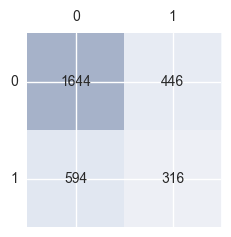

             precision    recall  f1-score   support

        NDF       0.73      0.79      0.76      2090
         US       0.41      0.35      0.38       910

avg / total       0.64      0.65      0.64      3000



In [27]:
from sklearn.metrics import confusion_matrix, classification_report

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j,y=i,s=mat[i,j], ha='center', va='center')
plt.show()
print(classification_report(y_test, y_pred))